In [ ]:
%pip install -r ../notebook_requirements.txt

In [3]:
import os
import sys

sys.path.append('..')

In [4]:
from pathlib import Path
from operator import itemgetter

import gin
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import auc

from src.game import Game, CircleL1
from train import train
from src.agents import Gaussian

In [5]:
def plot(logdir, savedir=None, name='error', last_epochs=10, show=True, verbose=True, individual_plot=False, metric="test_l1_error"):
    if savedir:
        savepath = Path(savedir)
        savepath.mkdir(exist_ok=True)
        
    logpath = Path(logdir)    

    config_file = next(logpath.glob('**/*.gin'))
    if verbose:
        print(f'config file {config_file}')
    gin.parse_config_file(config_file, skip_unknown=True)
    
    bias = gin.config.query_parameter('Game.bias')
    num_points = gin.config.query_parameter('Game.num_points')
    num_epochs = gin.config.query_parameter('train.num_epochs')
    test_loss = CircleL1(num_points)
    
    run_logs = []
    for path in logpath.glob('**/*.json'):
        if verbose:
            print(f'plotting from {path}')
        with open(path, 'r') as logfile:
            try:
                new_log = pd.read_json(logfile)
            except:
                print(f'JSON error in log at {path}')
            else:
                run_logs.append(new_log)

    logs = pd.concat(run_logs, ignore_index=True)
    sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
    recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])

    if show:
        # metric = "test_l1_error" if "test_l1_error" in sender else "test_error"
        
        if 'error' in metric:
            # Rewards
            if not individual_plot:
                sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
                sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")
            else:
                for i in range(5):
                    seed_sender = sender[i*num_epochs:(i+1)*num_epochs]
                    seed_recver = recver[i*num_epochs:(i+1)*num_epochs]
                    sns.lineplot(data=seed_sender, x="epoch", y=seed_sender[metric]*10, label="sender")
                    sns.lineplot(data=seed_recver, x="epoch", y=seed_recver[metric]*10, label="recver")
                    
                                        # Baselines
                    nocomm_diff = torch.tensor(36 / 4)
                    nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
                    fair_error = test_loss(torch.tensor(0.), bias/2)*10
                    plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
                    plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
                    
        else:
            sns.lineplot(data=sender, x="epoch", y=sender[metric], label="sender")
            # sns.lineplot(data=recver, x="epoch", y=recver[metric], label="receiver")
            
        if 'error' in metric:
            plt.ylabel(r'Test $L_1$ loss')
            nocomm_diff = torch.tensor(36 / 4)
            nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
            fair_error = test_loss(torch.tensor(0.), bias/2)*10
            plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
            plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
        elif 'drift' in metric:
            plt.ylabel(r'Message Drift')

        if savedir:
            plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
            
        plt.show()
        plt.clf()

    if 'error' in metric:
        error_sum = pd.DataFrame(sender['test_l1_error'] + recver['test_l1_error']).join(logs['epoch'])
        error_last = error_sum[error_sum['epoch'] >= num_epochs - last_epochs]
        seeds_metric = [error_last[i*last_epochs:(i+1)*last_epochs]['test_l1_error'].mean() for i in range(5)] 
    elif 'drift' in metric:
        drift = pd.DataFrame(sender['test_prev_drift']).join(logs['epoch'])
        drift_seeds = [drift[i*30:(i+1)*30] for i in range(5)]
        seeds_metric = [auc(df['epoch'], df['test_prev_drift']) for df in drift_seeds]
    
    return seeds_metric

    
def plot_hyperparam_results(results_dir, label='', savepath=None, last_epochs=10, show=True, title='', skip_18=True, metric="test_l1_error"):
    results_path = Path(results_dir)
    
    results = []
    for result_folder in results_path.iterdir():
        if not result_folder.is_dir():
            continue
        
        folder_name = result_folder.name
        
        if not 'bias' in folder_name:
            continue
        
        bias_index = folder_name.index('bias') + 4
        if int(folder_name[bias_index]) in [0,3,6,9]:
            bias = int(folder_name[bias_index])
        elif int(folder_name[bias_index]) == 1 and int(folder_name[bias_index+1]) in [2,5,8]:
            bias = int(folder_name[bias_index:bias_index+2])
        else:
            raise Exception(f'couldnt figure out bias of {folder_name}')
        
        results.append({
            'bias': bias,
            'name': f'{results_path.name}-bias{bias}',
            'path': result_folder,
        })
    
    df = pd.DataFrame()
    
    for bias_result in sorted(results, key=itemgetter('bias')):
        bias = bias_result['bias']
        folder_path = bias_result['path']
        name = bias_result['name']
        
        if bias == 18 and skip_18:
            continue

        try:
            print(f'Bias {bias}')
            seed_scores = plot(folder_path, savepath, name, last_epochs=last_epochs, show=show, verbose=False, metric=metric)  
            for score in seed_scores:
                df = df.append({**bias_result, 'seed_score':score}, ignore_index=True)
        except Exception as e:
            print(f'In {folder_path.name} error for bias {bias}')
            print(f'Exception {e}')   
    
   
    print(f'All Biases')

    if 'error' in metric:
        plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
        sns.lineplot(data=df, x=df['bias']*10, label=label, y=df['seed_score']*10)
        plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    elif 'drift' in metric:
        sns.lineplot(data=df, x=df['bias']*10, label=label, y=df['seed_score'])
        plt.ylabel(r'AUC of JSD over training')

    plt.title(title)
    plt.legend()
    if savepath is not None:
        savepath.mkdir(exist_ok=True)
        plt.savefig(savepath / f'{results_path.name}-all.png',  bbox_inches='tight')
    
    if show:
        plt.show()
        plt.clf()
    
    return df

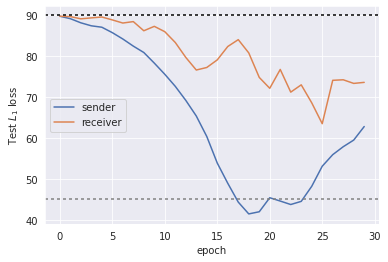

[12.364769983291627, nan, nan, nan, nan]

<Figure size 432x288 with 0 Axes>

In [15]:
plot('/mnt/public/results/emergent-compete/cat-deter-bias9/4/', None, '', last_epochs=10, show=True, verbose=False, metric="test_l1_error")

In [6]:
result_dir = Path('/mnt/home/emergent-compete/results/')

Bias 0


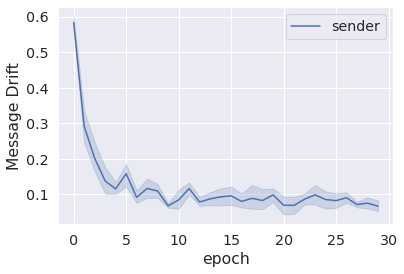

Bias 3


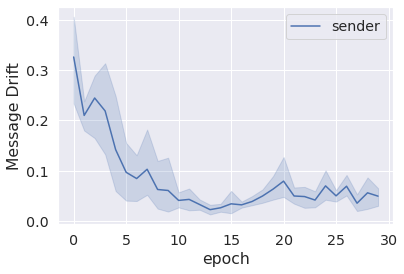

Bias 6


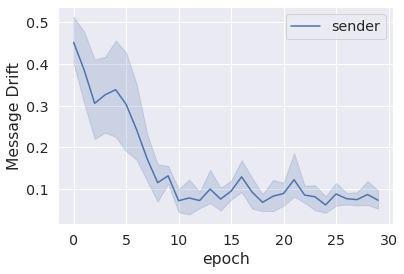

Bias 9


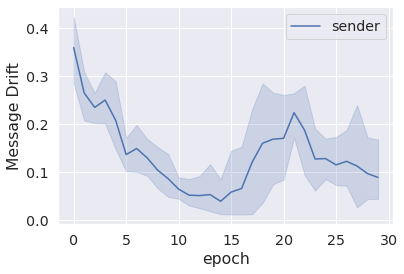

Bias 12


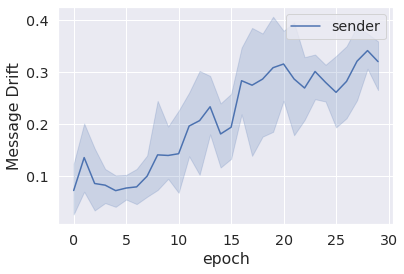

Bias 15


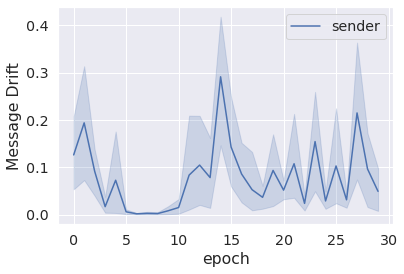

Bias 18


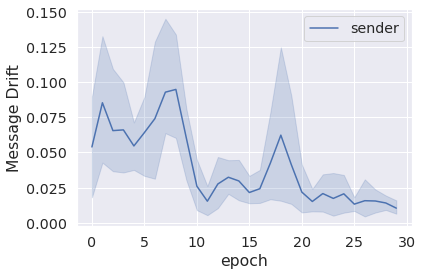

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All Biases


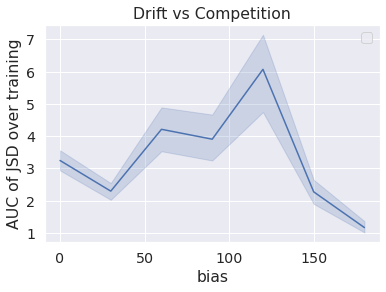

Bias 0


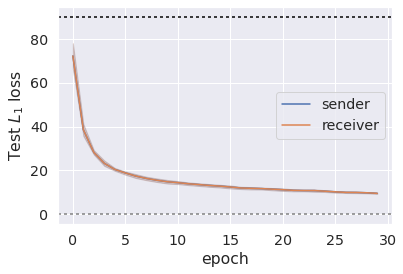

Bias 3


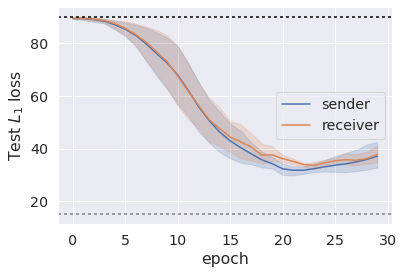

Bias 6


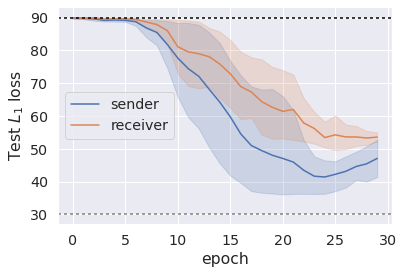

Bias 9


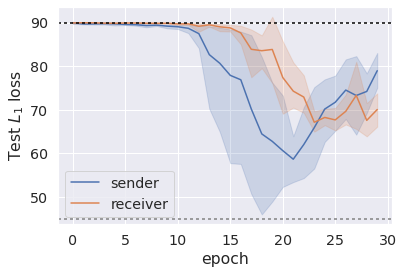

Bias 12


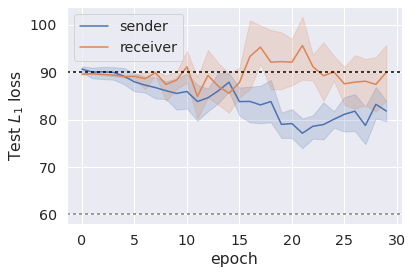

Bias 15


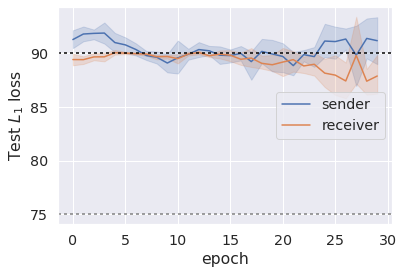

Bias 18


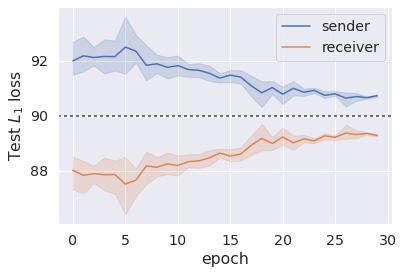

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All Biases


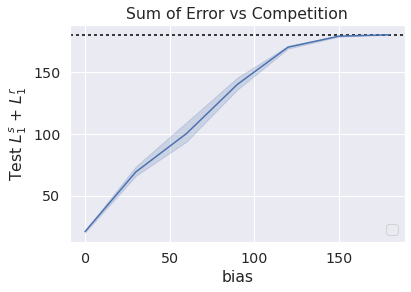

<Figure size 432x288 with 0 Axes>

In [7]:

resultspath = result_dir / 'best-scratch-cat-deter-drift'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Drift vs Competition', skip_18=False, metric="test_prev_drift")
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Sum of Error vs Competition', skip_18=False, metric="test_l1_error")



Bias 0


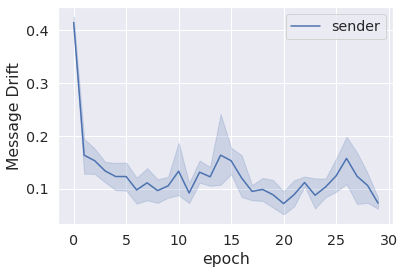

Bias 3


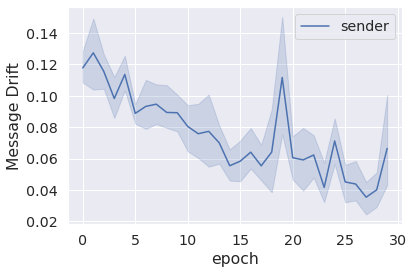

Bias 6


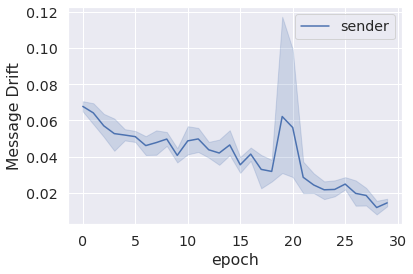

Bias 9


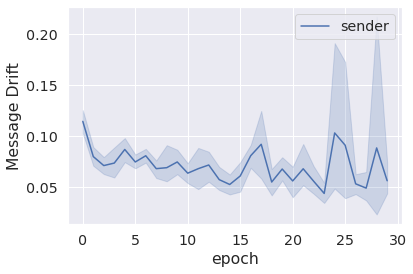

Bias 12


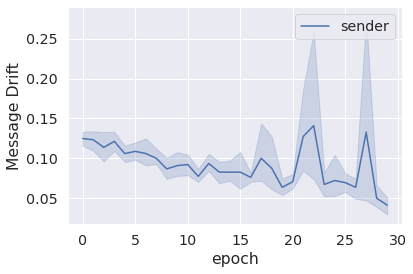

Bias 15


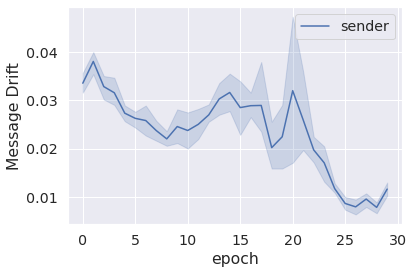

Bias 18


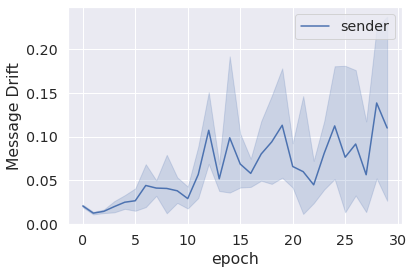

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All Biases


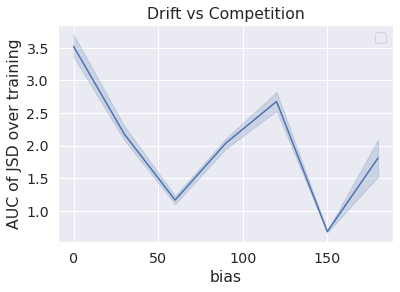

Bias 0


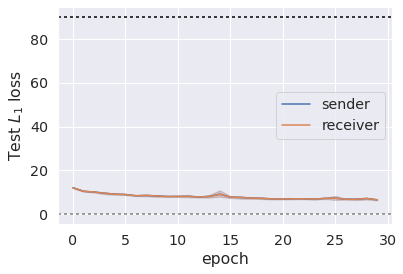

Bias 3


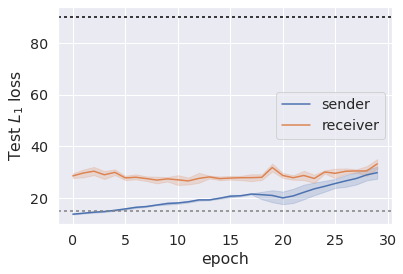

Bias 6


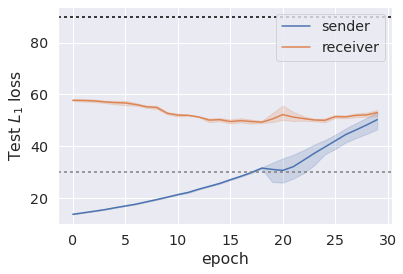

Bias 9


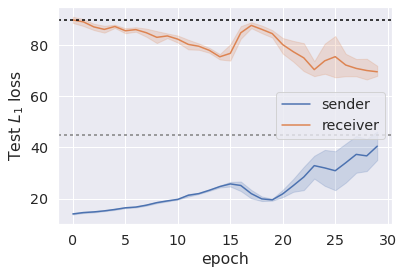

Bias 12


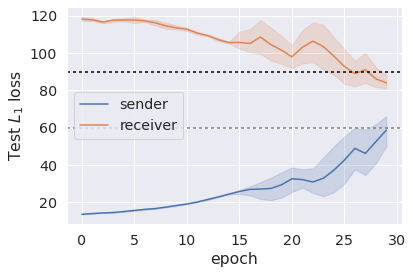

Bias 15


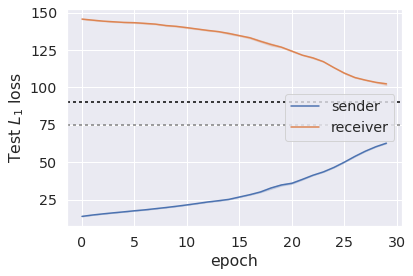

Bias 18


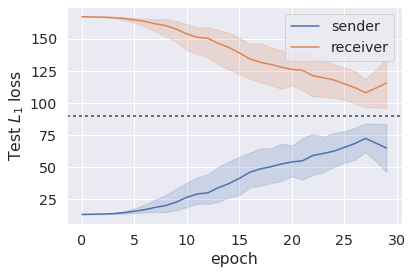

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


All Biases


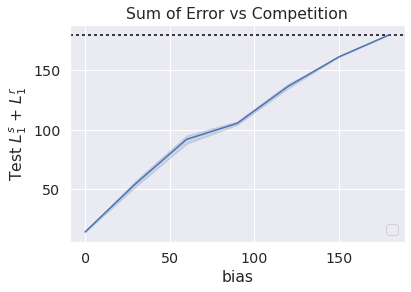

<Figure size 432x288 with 0 Axes>

In [10]:
# Drift

resultspath = result_dir / 'best-cat-deter-drift'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Drift vs Competition', skip_18=False, metric="test_prev_drift")
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Sum of Error vs Competition', skip_18=False, metric="test_l1_error")


    

Bias 0
In cat-deter-drift-bias0-73 error for bias 0
Exception 'test_prev_drift'
Bias 3
In cat-deter-drift-bias3-14 error for bias 3
Exception 'test_prev_drift'
Bias 6
In cat-deter-drift-bias6-48 error for bias 6
Exception 'test_prev_drift'
Bias 9
In cat-deter-drift-bias9-78 error for bias 9
Exception 'test_prev_drift'
Bias 12
In cat-deter-drift-bias12-77 error for bias 12
Exception 'test_prev_drift'
Bias 15
In cat-deter-drift-bias15-75 error for bias 15
Exception 'test_prev_drift'
Bias 18
In cat-deter-drift-bias18-85 error for bias 18
Exception 'test_prev_drift'
All Biases


KeyError: 'bias'

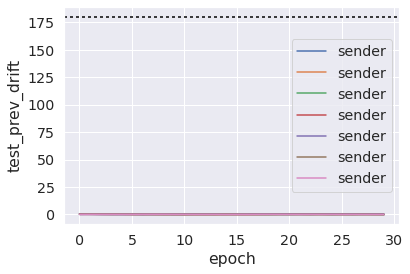

In [8]:
# Discrete Messages


resultspath = result_dir / 'best-cat-deter-drift'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)

    # plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Sum of Losses vs Bias', skip_18=False, metric="test_l1_error")
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Sum of Losses vs Bias', skip_18=False, metric="test_prev_drift")


    

Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases
Bias 0
Bias 3
Bias 6
Bias 9
Bias 12
Bias 15
All Biases


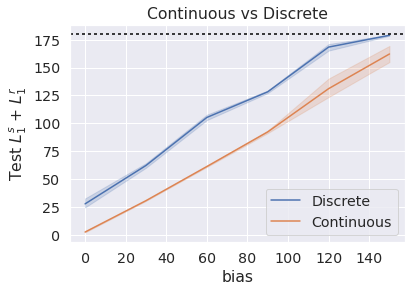

In [51]:
## Continuous v Discrete 

discrete_path = result_dir / 'cat-deter'
cont_path = result_dir / 'gauss-deter-dim1'

with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    
    label='Discrete'
    plot_hyperparam_results(discrete_path, label, discrete_path / 'plots', show=False)
    
    label='Continuous'
    plot_hyperparam_results(cont_path, label, cont_path / 'plots', show=False)

    plt.axhline(torch.tensor(360 / 2), color="black", dashes=(2,2,2,2))
    
    plt.ylabel(r'Test $L_1^s$ + $L_1^r$')
    plt.title('Continuous vs Discrete')
    plt.savefig(f'../results/discrete-v-continuous.png',  bbox_inches='tight')

Bias 0


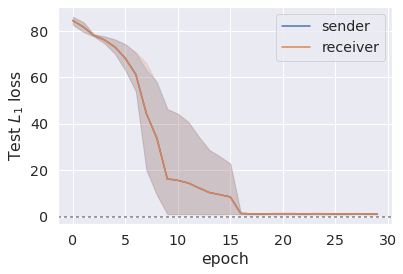

Bias 3


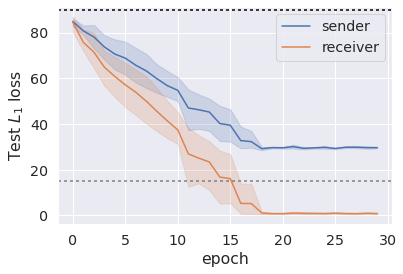

Bias 6


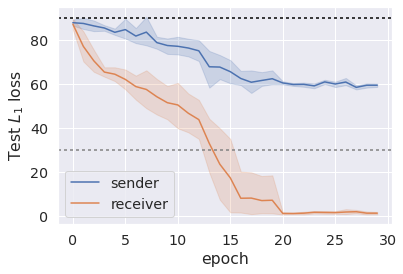

Bias 9


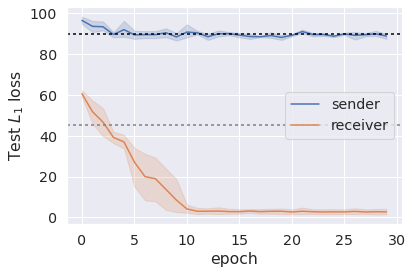

Bias 12


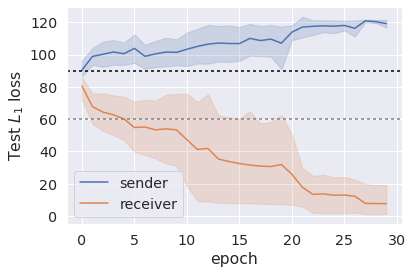

Bias 15


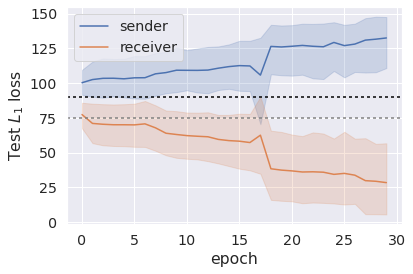

All Biases


No handles with labels found to put in legend.


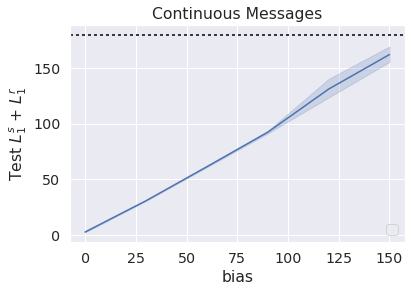

<Figure size 432x288 with 0 Axes>

In [39]:
## Continuous

resultspath = result_dir / 'gauss-deter-dim1'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Continuous Messages')

Bias 0


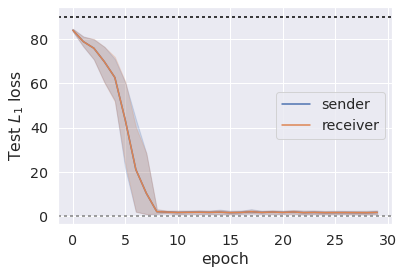

Bias 3


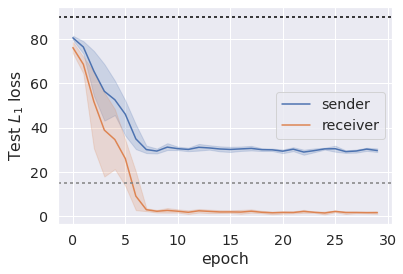

Bias 6


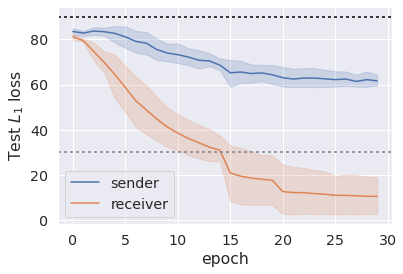

Bias 9


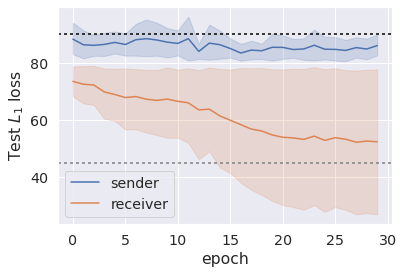

Bias 12


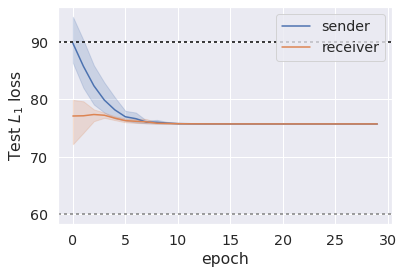

Bias 15


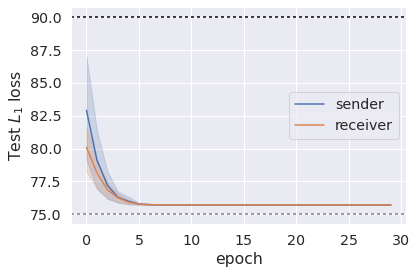

All Biases


No handles with labels found to put in legend.


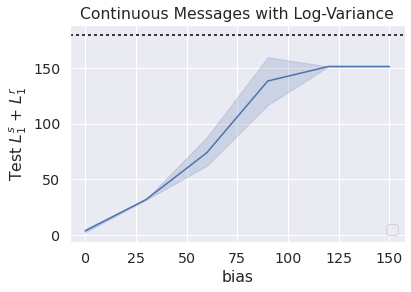

<Figure size 432x288 with 0 Axes>

In [44]:
## VarGauss

resultspath = result_dir / 'vargauss-deter'
with sns.plotting_context('paper'):
    sns.set(font_scale=1.3)
    plot_hyperparam_results(resultspath, savepath=resultspath / 'plots', title='Continuous Messages with Log-Variance')

In [10]:
logdir = Path('/mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73')

savedir=None
name='error'
last_epochs=10
show=True
verbose=True
individual_plot=False
metric="test_prev_drift"

if savedir:
    savepath = Path(savedir)
    savepath.mkdir(exist_ok=True)
    
logpath = Path(logdir)    

config_file = next(logpath.glob('**/*.gin'))
if verbose:
    print(f'config file {config_file}')
gin.parse_config_file(config_file, skip_unknown=True)

bias = gin.config.query_parameter('Game.bias')
num_points = gin.config.query_parameter('Game.num_points')
num_epochs = gin.config.query_parameter('train.num_epochs')
test_loss = CircleL1(num_points)

run_logs = []
for path in logpath.glob('**/*.json'):
    if verbose:
        print(f'plotting from {path}')
    with open(path, 'r') as logfile:
        try:
            new_log = pd.read_json(logfile)
        except:
            print(f'JSON error in log at {path}')
        else:
            run_logs.append(new_log)

logs = pd.concat(run_logs, ignore_index=True)
sender = pd.DataFrame(logs['sender'].to_list()).join(logs['epoch'])
recver = pd.DataFrame(logs['recver'].to_list()).join(logs['epoch'])


config file /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/0/config.gin
plotting from /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/0/logs.json
plotting from /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/1/logs.json
plotting from /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/2/logs.json
plotting from /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/3/logs.json
plotting from /mnt/home/emergent-compete/results/best-cat-deter-drift/cat-deter-drift-bias0-73/4/logs.json


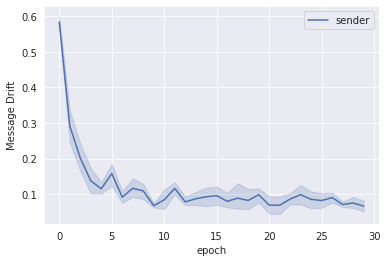

<Figure size 432x288 with 0 Axes>

In [15]:
if show:
    # metric = "test_l1_error" if "test_l1_error" in sender else "test_error"
    
    if 'error' in metric:
        # Rewards
        if not individual_plot:
            sns.lineplot(data=sender, x="epoch", y=sender[metric]*10, label="sender")
            sns.lineplot(data=recver, x="epoch", y=recver[metric]*10, label="receiver")
        else:
            for i in range(5):
                seed_sender = sender[i*num_epochs:(i+1)*num_epochs]
                seed_recver = recver[i*num_epochs:(i+1)*num_epochs]
                sns.lineplot(data=seed_sender, x="epoch", y=seed_sender[metric]*10, label="sender")
                sns.lineplot(data=seed_recver, x="epoch", y=seed_recver[metric]*10, label="recver")
                
                                    # Baselines
                nocomm_diff = torch.tensor(36 / 4)
                nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
                fair_error = test_loss(torch.tensor(0.), bias/2)*10
                plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
                plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
                
    else:
        sns.lineplot(data=sender, x="epoch", y=sender[metric], label="sender")
        # sns.lineplot(data=recver, x="epoch", y=recver[metric], label="receiver")

        # plt.show()
        # plt.clf()


        
    # Baselines


    if 'error' in metric:
        plt.ylabel(r'Test $L_1$ loss')
        nocomm_diff = torch.tensor(36 / 4)
        nocomm_error = test_loss(torch.tensor(0.), nocomm_diff)*10
        fair_error = test_loss(torch.tensor(0.), bias/2)*10
        plt.axhline(nocomm_error, label='no communication', color="black", dashes=(2,2,2,2))
        plt.axhline(fair_error, label='fair split', color="grey", dashes=(2,2,2,2))
    elif 'drift' in metric:
        plt.ylabel(r'Message Drift')
        
    if savedir:
        plt.savefig(savepath / f'{name}.png',  bbox_inches='tight')
        
    plt.show()
    plt.clf()